[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.12.3
[Taichi] Starting on arch=cuda


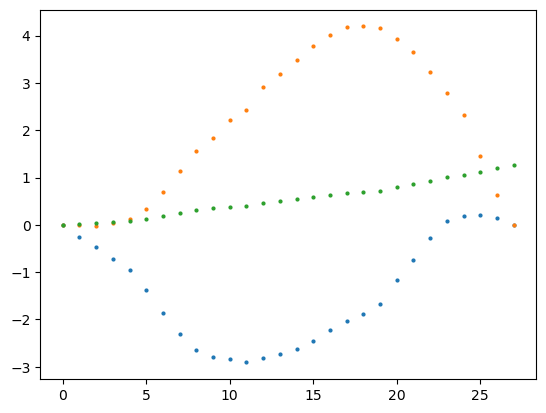

In [1]:
import numpy as np
# from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import taichi as ti
from utils import get_sofa, monotonicly_interpolate
from PIL import Image
# from IPython.display import display

ti.init(arch=ti.gpu)

# xs, ys, rotations = np.load('../trajectory/双拐角_offset2.0/sofa_488.npy')
# xs, ys, rotations = np.load('../trajectory/双拐角_offset1/sofa_3394.npy')
# xs, ys, rotations = np.load('../trajectory/180°拐角/sofa_1302.npy')
xs, ys, rotations = np.load('../trajectory/5花瓣房间/sofa_1500.npy')

# 数据点
plt.plot(xs, 'o', markersize=2)
plt.plot(ys, 'o', markersize=2)
plt.plot(rotations, 'o', markersize=2)

# 插值结果
# plt.plot(zoom(xs, zoom=101, order=1))
# plt.plot(zoom(ys, zoom=101, order=1))
# plt.plot(zoom(rotations, zoom=101, order=1))

In [3]:
np.min(rotations) / np.pi

-0.18763349929318296

In [4]:
np.min(ys), np.max(ys)

(-0.5013455347971678, 0.5010212427014039)

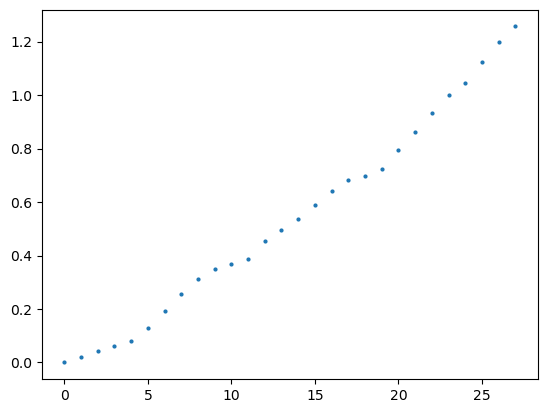

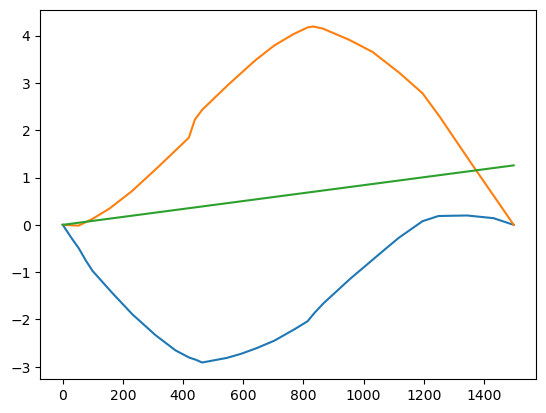

In [2]:
def key_function(xs, ys, rotations):  # 要求这个函数单调递增来重新采样
    # keys = xs - ys - rotations * 0.5
    # keys = xs - ys
    # return xs - ys - (ys + 0.5) * rotations * 0.3  # 适配双拐角沙发（offset = 2）
    # return xs - ys - (ys + 0) * rotations * 0.4  # 适配双拐角沙发（offset = 1）
    # return -rotations * 1 - ys * 1 + np.sign(np.pi / 2 + rotations + ys) * (xs - 0.5) * 1  # 适配180°拐角沙发
    return rotations  # 适配180°拐角沙发

keys = key_function(xs, ys, rotations)
plt.plot(keys, 'o', markersize=2)
plt.show()

xs_monotonic, ys_monotonic, rotations_monotonic = monotonicly_interpolate(
    keys,
    np.array([xs, ys, rotations]).T,
    1500,
    key_min=keys[0],
    key_max=keys[-1]
).T
plt.plot(xs_monotonic)
plt.plot(ys_monotonic)
plt.plot(rotations_monotonic)

Area = 0.22229066666666666


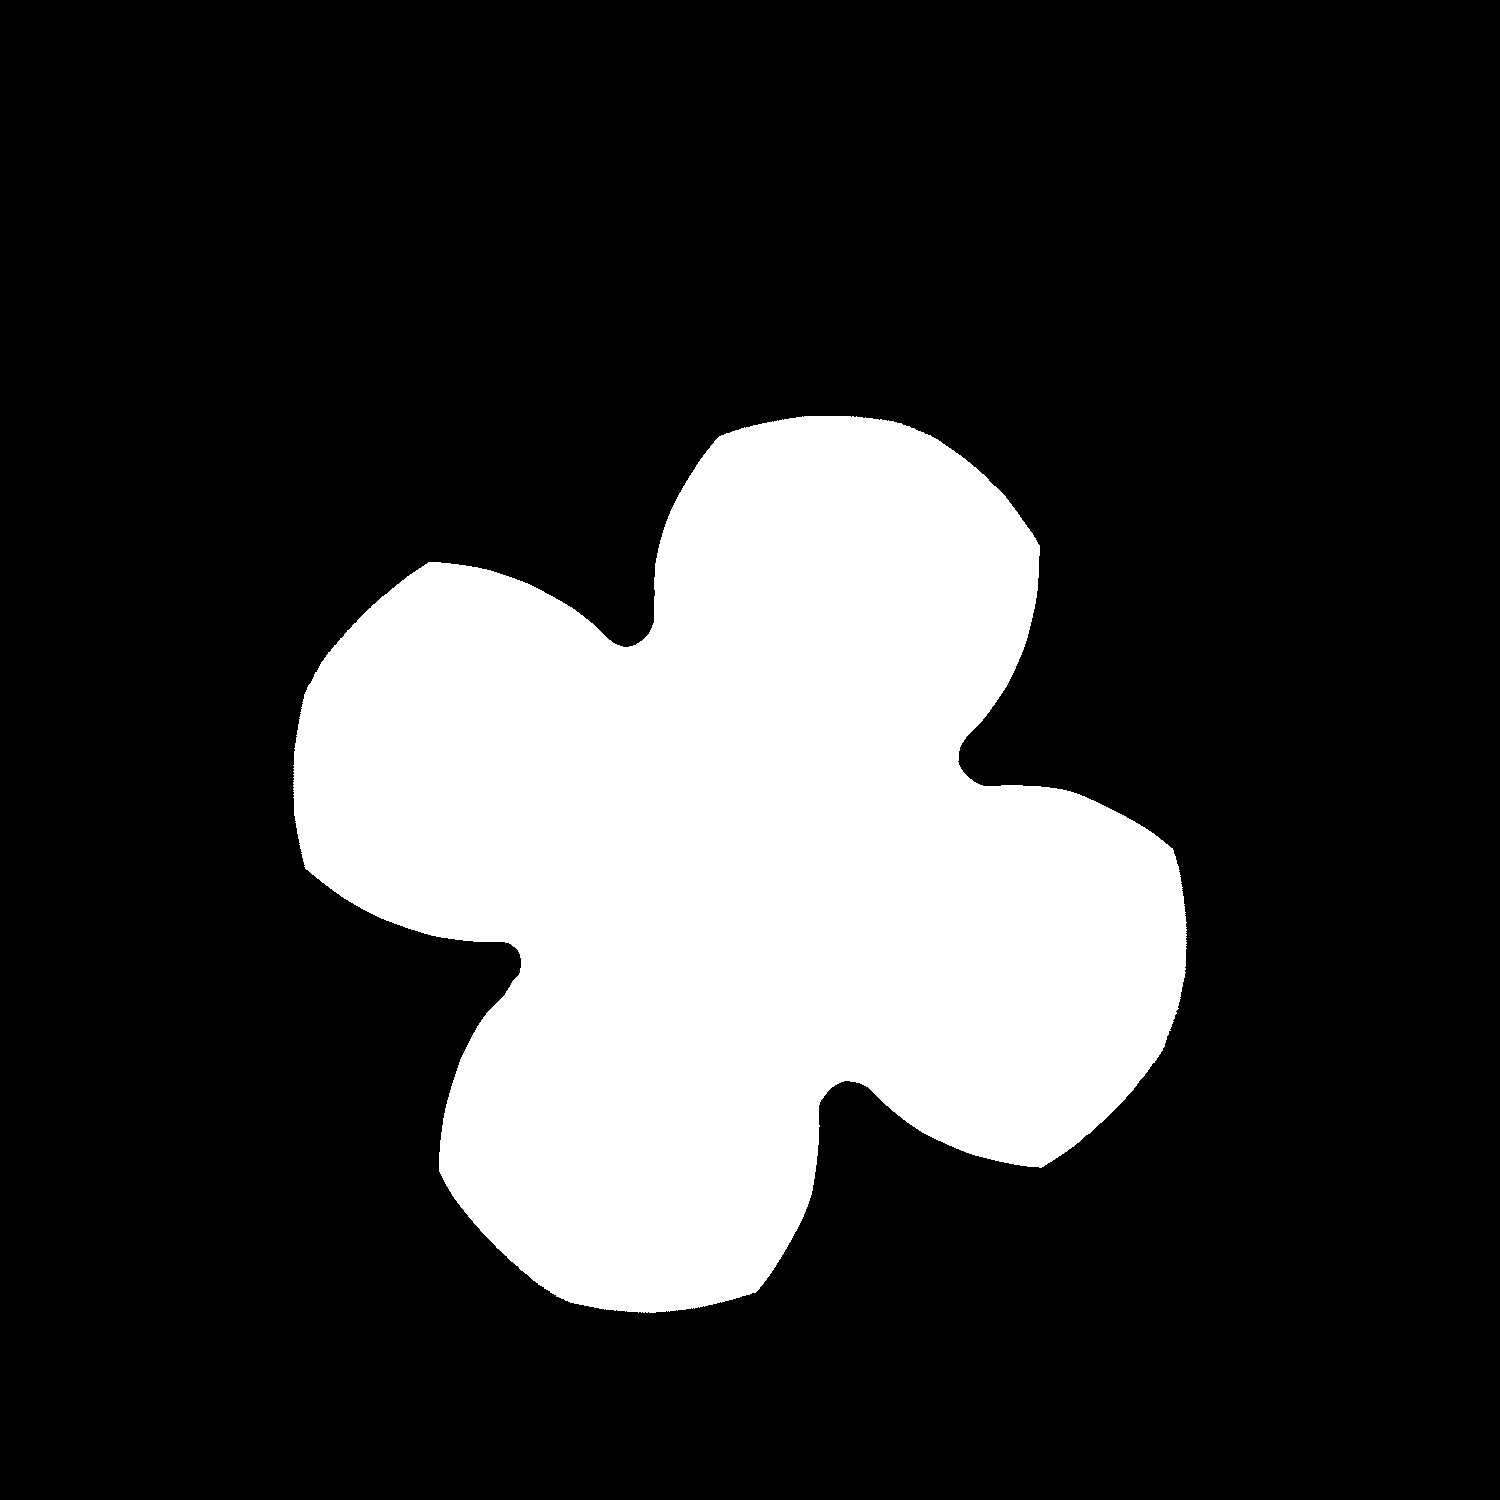

In [3]:
offset = 1

# @ti.func
# def is_forbidden(x, y):  # 指定哪里是墙（双拐角）
#     return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

# @ti.func
# def is_forbidden(x1, y1, x2, y2):  # 指定哪里是墙（180°拐角）
#     return y2 < -1 or y2 > 1 or x2 > 1 or (x2 < 0 and y1 * y2 < 0)  # 括号里的内容制定了无穷薄但不能穿过的墙

r1, r2, r3 = 0, 7, 15  # 走廊形状参数 0, 7, 11 0, 7, 15
teeth_count = 4  # 齿轮齿数 10
sofa_w = r3 * 2  # 求解域的尺寸
sofa_h = sofa_w  # 求解域的尺寸
@ti.func
def is_forbidden(x, y):  # 指定哪里是墙（花瓣房间）
    r = (x ** 2 + y ** 2) ** 0.5
    a = ti.atan2(y, x)
    a = a / (2 * np.pi) * (teeth_count + 1)  # 外圈必须比内圈多一齿
    r_wall = r2 + (r3 - r2) * 2 * ti.abs(a - ti.round(a))  # 三角波
    return r < r1 or r > r_wall

# sofa, survive_mask = get_sofa(is_forbidden, xs, ys, rotations, resolution=2000, trajectory_upsampling=101, return_hitting_time=True)
sofa, survive_mask = get_sofa(
    is_forbidden, xs_monotonic, ys_monotonic, rotations_monotonic, resolution=1500,
    sofa_w=sofa_w, sofa_h=sofa_h,
    trajectory_upsampling=1, return_hitting_time=True)
print(f'Area = {np.sum(sofa) / min(*sofa.shape) ** 2}')

image = Image.fromarray(np.array(sofa.T[::-1] * 255, dtype=np.uint8))
image

In [ ]:
# # 渲染单个沙发的动画

# from tqdm.notebook import tqdm
# import os
# from PIL import ImageDraw
# from animation_tools import generate_animated_sofa, draw_sofa

# offset = 1

# @ti.func
# def is_forbidden(x, y):  # 指定哪里是墙。双拐角
#     return y < -offset or y > 1 or (x < 0.0 and y < 0.0) or (x > 1.0 and y > -offset + 1.0)

# frames = 150
# sofa = generate_animated_sofa(
#     is_forbidden,
#     'trajectory/双拐角_offset1/sofa_',
#     3394,  # 文件编号
#     0,  # 起始时刻
#     frames,  # 时长
#     int(300 * 3.5 * 2),  # 分辨率
#     draw_text=False
# )

# resolution = (1600, 800)
# scale = 300
# origin = (resolution[0] // 2 - scale // 2, resolution[1] // 2)

# for frame in tqdm(range(frames)):
# # for frame in [75]:
#     rendering_target = Image.new('RGB', resolution, (180, 180, 180))  # 背景
#     draw = ImageDraw.Draw(rendering_target)

#     # 绘制道路
#     line_width = 4
#     draw.polygon([
#             (-10, origin[1] - scale - line_width // 2 - 1),
#             (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
#             (origin[0] + scale + line_width // 2, origin[1] - line_width // 2 - 1),
#             (resolution[0] + 10, origin[1] - line_width // 2 - 1),
#             (resolution[0] + 10, origin[1] + scale + line_width // 2),
#             (origin[0] - line_width // 2 - 1, origin[1] + scale + line_width // 2),
#             (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
#             (-10, origin[1] + line_width // 2)
#         ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
#     draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)  # 补拐角
#     draw.rectangle((origin[0] + scale - line_width // 2 + 1, origin[1] - line_width // 2 - 1, origin[0] + scale + line_width // 2 - 1, origin[1] + line_width // 2 - 2), fill=(0, 0, 0), width=0)  # 补拐角

#     # 绘制沙发
#     draw_sofa(rendering_target, origin, scale, sofa['image'], sofa['xs'], sofa['ys'], sofa['rotations'], frame - sofa['start_time'])

#     rendering_target.save(f"rendering_results/紧挨的两个拐角/{frame}.png", compress_level=6)

In [4]:
# 适配单拐角沙发
# def id_function(i):
#     # return int(16 * 1.43 ** i - 5 * i - 16)
#     return int(16 * 1.37649 ** i - 5 * i - 16)

# 适配双拐角沙发（offset = 2）
# def id_function(i):
#     return int(14.45 * (1.21 ** i - 1) - 2 * i)

# 适配双拐角沙发（offset = 1）
# def id_function(i):
#     return int(1.5235 * (1.5 ** i - 1) - -1 * i)

# 适配180°拐角沙发
def id_function(i):
    return int(0.6685 * (1.5 ** i - 1) - -1 * i)

[id_function(i) for i in range(20)]

[0,
 1,
 2,
 4,
 6,
 9,
 12,
 17,
 24,
 34,
 47,
 68,
 98,
 142,
 208,
 307,
 454,
 674,
 1005,
 1500]

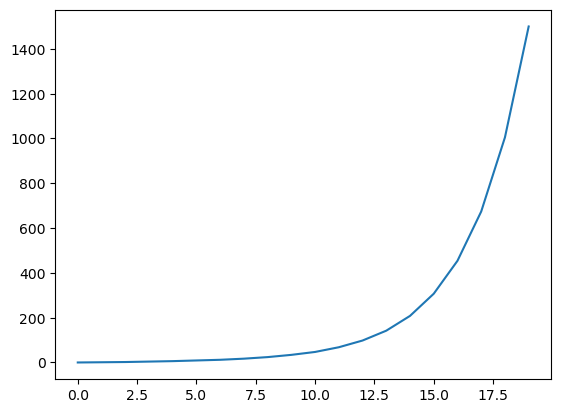

In [5]:
plt.plot([id_function(i) for i in range(20)])

In [6]:
@ti.kernel
def dilate_kernel(input_img: ti.template(), output_img: ti.template(), radius: int):
    """形态学膨胀核心kernel"""
    height, width = input_img.shape
    
    for i, j in input_img:
        max_val = input_img[i, j]
        
        # 在圆形结构元素范围内搜索最大值
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                # 检查边界
                ni = i + di
                nj = j + dj
                
                if 0 <= ni < height and 0 <= nj < width:
                    # 计算当前像素与中心像素的距离
                    distance = ti.sqrt(di * di + dj * dj)
                    if distance <= radius:
                        current_val = input_img[ni, nj]
                        if current_val > max_val:
                            max_val = current_val
        
        output_img[i, j] = max_val

def dilate(image: np.ndarray, radius: int) -> np.ndarray:
    """
    对二维图像进行形态学膨胀操作
    
    Args:
        image: 输入图像，二维numpy数组
        radius: 膨胀半径（结构元素半径）
        
    Returns:
        膨胀后的图像，二维numpy数组
    """
    # 确保输入是二维数组
    if len(image.shape) != 2:
        raise ValueError("输入图像必须是二维数组")
    
    # 将numpy数组转换为taichi字段
    height, width = image.shape
    img_field = ti.field(ti.f32, shape=(height, width))
    img_field.from_numpy(image.astype(np.float32))
    
    # 创建输出字段
    result_field = ti.field(ti.f32, shape=(height, width))
    
    # 执行膨胀操作
    dilate_kernel(img_field, result_field, radius)
    
    # 返回numpy数组
    return result_field.to_numpy()

In [7]:
# 渲染若干个沙发依次经过拐角的动画

from PIL import ImageDraw
from tqdm.notebook import tqdm
import os
from utils import test_forbidden_function
from animation_tools import draw_sofa, generate_animated_sofa

resolution = (2560, 1440)
# origin = (1250, 550)  # 适配双拐角沙发（offset = 2）
# origin = (1250, 550)  # 适配双拐角沙发（offset = 1）
origin = [e // 2 for e in resolution]  # 适配花瓣房间
scale = 40  # 单位1对应多少像素
time_scale = 1.0

path = '../trajectory/5花瓣房间/'
output_path = '../rendering_results/5花瓣房间/'

background_upsampling = 3
background = test_forbidden_function(
    is_forbidden,
    -origin[0] / scale, (resolution[0] - origin[0]) / scale,
    -origin[1] / scale, (resolution[1] - origin[1]) / scale,
    [e * background_upsampling for e in resolution]
)
background = background.T[::-1]
background_dilate = 1 - dilate(1 - background, radius=4 * background_upsampling)
background = np.array((255 - background * 75) * (1 - np.logical_xor(background, background_dilate)), dtype=np.uint8)
background = np.stack([background, background, background], axis=-1)
background = Image.fromarray(background)
background = background.resize((background.width // background_upsampling, background.height // background_upsampling))

# 如果输出路径不存在，构建路径
if not os.path.exists(output_path):
    os.makedirs(output_path)

active_sofas = {}
emit_every_frames = int(90 * time_scale)
for frame in tqdm(range(emit_every_frames * 19 + int((90 + 140) * time_scale))):
# for frame in tqdm(range(100)):
    # 加入新的沙发
    if frame % emit_every_frames == 0:
        id = id_function(frame // emit_every_frames)
        # id = 488
        if os.path.exists(f'{path}sofa_{id}.npy'):
            def data_post_process(xs, ys, rotations):
                result = [[], [], []]
                for i in range(5):
                    rotation = i * rotations[-1]
                    rotation_matrix = np.array([
                        [np.cos(rotation), -np.sin(rotation)],
                        [np.sin(rotation), np.cos(rotation)]
                    ])
                    xys_rotated = rotation_matrix @ np.array([xs[:-1], ys[:-1]])
                    result[0].append(xys_rotated[0])
                    result[1].append(xys_rotated[1])
                    result[2].append(rotations[:-1] + rotation)
                return [np.concatenate(e) for e in result]

            active_sofas[str(frame // emit_every_frames)] = generate_animated_sofa(
                is_forbidden,
                f'{path}sofa_',
                id,
                # frame + int(90 * time_scale),  # 适配大多数动画
                frame,  # 适配花瓣房间
                int(90 * time_scale),
                int(scale * sofa_w * 2),
                sofa_w=sofa_w,
                sofa_h=sofa_h,
                key_function=key_function,  # （适用于双拐角）
                id_factor=10,  # 83
                text_size_factor=0.06,  # 文字尺寸（单拐角）
                # text_size_factor=0.045,  # 文字尺寸（双拐角）
                # text_color=(0, 0, 0),
                # trajectory_updampling=10
                data_post_process=data_post_process,
                area_factor=(1 / 7) ** 2
            )

    rendering_target = background.copy()

    # rendering_target = Image.new('RGB', resolution, (180, 180, 180))  # 背景
    # draw = ImageDraw.Draw(rendering_target)

    # 绘制道路（单拐角）
    # line_width = 4
    # draw.polygon([
    #         (-10, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, rendering_target.size[1] + 10),
    #         (origin[0] - line_width // 2 - 1, rendering_target.size[1] + 10),
    #         (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
    #         (-10, origin[1] + line_width // 2)
    #     ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
    # draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)

    # 绘制道路（双拐角）
    # line_width = 4
    # draw.polygon([
    #         (-10, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale + scale * offset - line_width // 2 - 1),
    #         (resolution[0] + 10, origin[1] - scale + scale * offset - line_width // 2 - 1),
    #         (resolution[0] + 10, origin[1] + scale * offset + line_width // 2),
    #         (origin[0] - line_width // 2 - 1, origin[1] + scale * offset + line_width // 2),
    #         (origin[0] - line_width // 2 - 1, origin[1] + line_width // 2),
    #         (-10, origin[1] + line_width // 2)
    #     ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)
    # draw.rectangle((origin[0] - line_width // 2, origin[1] - line_width // 2 + 1, origin[0] + line_width // 2 - 2, origin[1] + line_width // 2), fill=(0, 0, 0), width=0)  # 补拐角
    # draw.rectangle((origin[0] + scale - line_width // 2 + 1, origin[1] - scale + scale * offset - line_width // 2 - 1, origin[0] + scale + line_width // 2 - 1, origin[1] - scale + scale * offset + line_width // 2 - 2), fill=(0, 0, 0), width=0)  # 补拐角

    # 绘制道路（180°拐角）
    # line_width = 4
    # draw.polygon([
    #         (-10, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] - scale - line_width // 2 - 1),
    #         (origin[0] + scale + line_width // 2, origin[1] + scale + line_width // 2 - 1),
    #         (-10, origin[1] + scale + line_width // 2 - 1)
    #     ], fill=(255, 255, 255), outline=(0, 0, 0), width=line_width)

    # 绘制沙发
    for key in list(active_sofas.keys()):
        # if frame - active_sofas[key]['start_time'] >= int(140 * time_scale):  # 适配大多数动画
        if frame - active_sofas[key]['start_time'] >= 90 * time_scale:  # 适配花瓣房间
            del active_sofas[key]  # 删除已经移出显示区域的沙发
            continue
        draw_sofa(
            rendering_target, origin, scale, active_sofas[key]['image'], active_sofas[key]['xs'], active_sofas[key]['ys'], active_sofas[key]['rotations'], frame - active_sofas[key]['start_time'],
            sofa_h=sofa_h
        )

    # draw.line([(-10, origin[1] - 1), (origin[0], origin[1] - 1)], fill=(0, 0, 0), width=line_width)  # 绘制中间的墙（适用于180°拐角）

    rendering_target.save(f"{output_path}{frame}.png", compress_level=6)

    # if frame > 170:
    #     break
    # break
# rendering_target

  0%|          | 0/1940 [00:00<?, ?it/s]

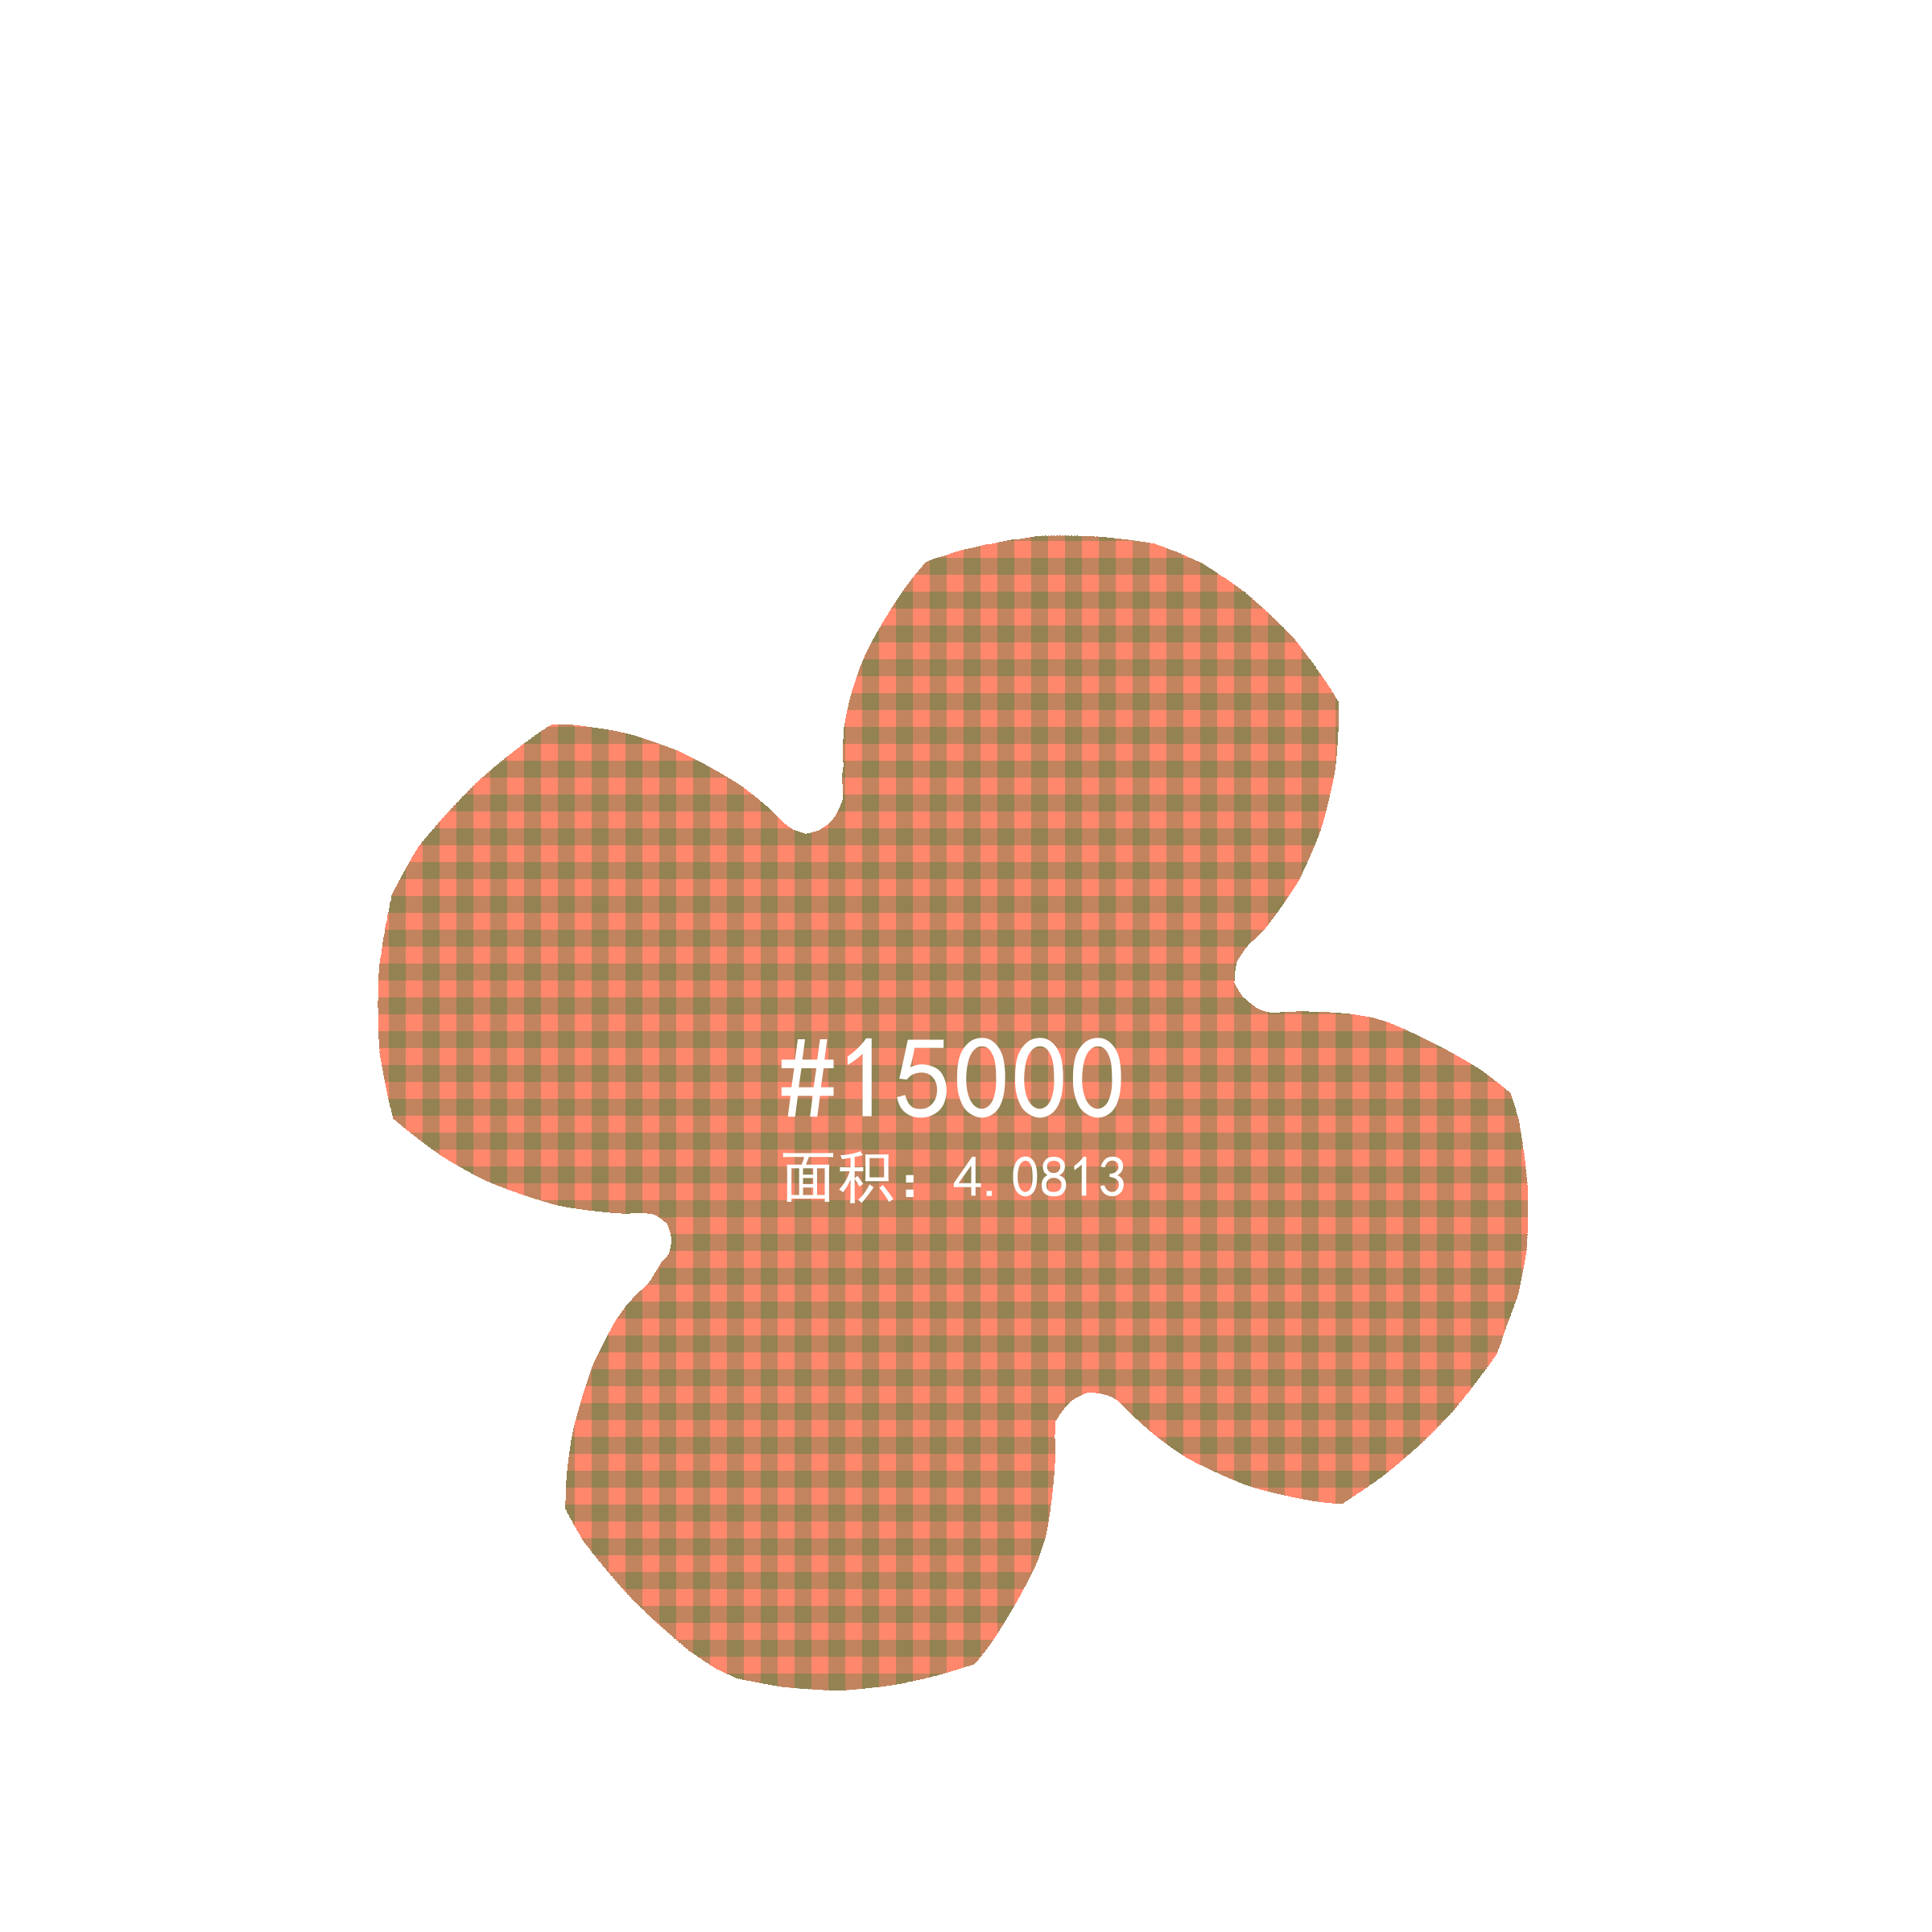

In [11]:
generate_animated_sofa(
    is_forbidden,
    f'{path}sofa_',
    1500,
    frame + int(90 * time_scale),
    int(90 * time_scale),
    int(scale * sofa_w * 2),
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    key_function=key_function,  # （适用于双拐角）
    id_factor=10,  # 83
    draw_text=True,
    text_size_factor=0.06,  # 文字尺寸（单拐角）
    # text_size_factor=0.045,  # 文字尺寸（双拐角）
    # trajectory_updampling=10
    area_factor=(1 / 7) ** 2
)['image']

In [9]:
import winsound

winsound.MessageBeep()  # 播放系统提示音